In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from scipy.stats import chi2_contingency

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import GlorotUniform
from keras.initializers import HeUniform
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adamax, Nadam, Ftrl
from keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

TEST_SIZE = 0.2

2024-09-29 23:03:07.353600: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 23:03:07.679093: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 23:03:07.679128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 23:03:07.680801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 23:03:07.869184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 23:03:07.871381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

-------------------------


In [2]:
# Import del dataset e divisione in train e test
train_df = pd.read_csv('datasets/InternetAddiction.csv')
train_df.rename(columns={'sii':'label'}, inplace=True)
train_df = train_df.dropna(subset=['label'])

# Viene diviso il train set in train e validation set
train, test_df = train_test_split(train_df, test_size = TEST_SIZE, random_state = 42)
train_df, val_df = train_test_split(train, test_size = TEST_SIZE, random_state = 42)

train_x = train_df.drop(columns=['label'])
train_y = train_df['label'].astype(int)

val_x = val_df.drop(columns=['label'])
val_y = val_df['label'].astype(int)

test_x = test_df.drop(columns=['label'])
test_y = test_df['label'].astype(int)

In [4]:
def nan_values(dataset):
    dataset = dataset.drop(columns=['id'])
    for col in dataset.columns:
        if dataset[col].isnull().sum() > 0:
            if (dataset[col].dtype == 'object') | (dataset[col].dtype == 'bool'):
                dataset[col].fillna(dataset[col].mode()[0], inplace=True)
            else:
                dataset[col].fillna(dataset[col].mean(), inplace=True)
    return dataset

def fs(dataset, dataset_y):
    str_path = 'objects/features_internet.npy'

    if not os.path.exists(str_path):
        dataset['label'] = dataset_y
        correlation_matrix=dataset.corr()
        features = correlation_matrix['label'][(correlation_matrix['label']>=0.1) | (correlation_matrix['label']<=-0.1)].index
        features = features.drop('label')
        print(correlation_matrix['label'].sort_values(ascending=False))
        print(len(features))
        np.save(str_path, features)
    features = np.load(str_path, allow_pickle=True)
    return dataset[features]

def encode(dataset, dataset_y):
    dataset = nan_values(dataset)
    fill_dict = {col: dataset[col].mean() if dataset[col].dtype != 'object' else dataset[col].mode()[0] for col in dataset.columns}
    cat_cols = dataset.select_dtypes(include='object').columns
    num_cols = dataset.select_dtypes(exclude='object').columns
    print(dataset.dtypes)
    scaler = StandardScaler()
    dataset[num_cols] = scaler.fit_transform(dataset[num_cols])

    encoder = OrdinalEncoder()
    dataset[cat_cols] = encoder.fit_transform(dataset[cat_cols])

    dataset = fs(dataset, dataset_y)

    return dataset.astype(float), scaler, encoder, fill_dict




In [5]:
def preproc_test_val(dataset, scaler, encoder, mean):
    dataset = dataset.drop(columns=['id'])
    for key in mean.keys():
        dataset[key].fillna(mean[key], inplace=True)

    cat_cols = dataset.select_dtypes(include='object').columns
    num_cols = dataset.select_dtypes(exclude='object').columns
    dataset[num_cols] = scaler.transform(dataset[num_cols])
    dataset[cat_cols] = encoder.transform(dataset[cat_cols])

    features = np.load('objects/features_internet.npy', allow_pickle=True)
    dataset = dataset[features]
    dataset = dataset.astype(float)
    return dataset

In [6]:
train_x, scaler, encoder, mean = encode(train_x, train_y)
val_x = preproc_test_val(val_x, scaler, encoder, mean)
test_x = preproc_test_val(test_x, scaler, encoder, mean)

Basic_Demos-Enroll_Season                  object
Basic_Demos-Age                             int64
Basic_Demos-Sex                             int64
CGAS-Season                                object
CGAS-CGAS_Score                           float64
                                           ...   
SDS-Season                                 object
SDS-SDS_Total_Raw                         float64
SDS-SDS_Total_T                           float64
PreInt_EduHx-Season                        object
PreInt_EduHx-computerinternet_hoursday    float64
Length: 80, dtype: object


In [7]:
EPOCHS = 1000
BATCH_SIZE = 512
DROPOUT = 0.2
classes = 4

train_y = to_categorical(train_y)
val_y = to_categorical(val_y)
test_y = to_categorical(test_y)

np.random.seed(42)
tf.random.set_seed(42)
def model_fn():
    # Initialising the NN
    model = Sequential()

    # layers
    model.add(Dense(112, activation='softmax', input_dim=train_x.shape[-1]))
    model.add(Dropout(DROPOUT))
    model.add(Dense(272, activation='tanh'))
    model.add(Dropout(DROPOUT))
    model.add(Dense(classes,  kernel_initializer='normal', activation='softmax'))   

    # summary
    model.summary()
    return model

model = model_fn()
# Compiling the NN
initial_learning_rate = 0.01
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/100)
steps_per_epoch = int(train_x.shape[0]/BATCH_SIZE)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Train the NN
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_x, train_y,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_cb],
                    validation_data=(val_x, val_y))

EPOCHS = len(history.history['loss'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 112)               5040      
                                                                 
 dropout (Dropout)           (None, 112)               0         
                                                                 
 dense_1 (Dense)             (None, 272)               30736     
                                                                 
 dropout_1 (Dropout)         (None, 272)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1092      
                                                                 
Total params: 36868 (144.02 KB)
Trainable params: 36868 (144.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-09-29 23:04:12.515184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-29 23:04:12.516010: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/1000
4/4 [==============================] - 1s 93ms/step - loss: 1.2512 - accuracy: 0.4509 - val_loss: 0.9437 - val_accuracy: 0.5799
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8762 - accuracy: 0.5754 - val_loss: 0.6854 - val_accuracy: 0.6324
Epoch 3/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5994 - accuracy: 0.7269 - val_loss: 0.5002 - val_accuracy: 0.8630
Epoch 4/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.4314 - accuracy: 0.8600 - val_loss: 0.4022 - val_accuracy: 0.8721
Epoch 5/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.3352 - accuracy: 0.8817 - val_loss: 0.3238 - val_accuracy: 0.9087
Epoch 6/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.2703 - accuracy: 0.9040 - val_loss: 0.2488 - val_accuracy: 0.9201
Epoch 7/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.2250 - accuracy: 0.9171 - val_loss: 0.2015 - val_accuracy: 0.9384
Epoch 8/1000


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


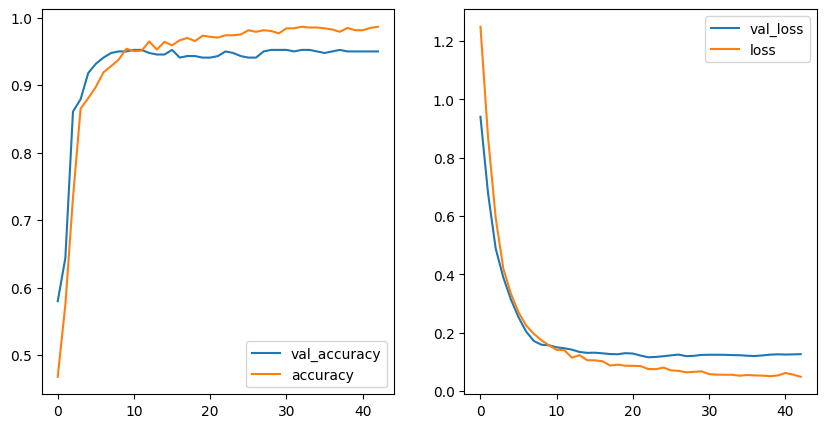

In [11]:
print(history.history.keys())
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(history.history['val_accuracy'])
axs[0].plot(history.history['accuracy'])
axs[0].legend(['val_accuracy', 'accuracy'])

axs[1].plot(history.history['val_loss'])
axs[1].plot(history.history['loss'])
axs[1].legend(['val_loss', 'loss'])

In [8]:
score = model.evaluate(test_x, test_y)

18/18 [==============================] - 0s 3ms/step - loss: 0.0805 - accuracy: 0.9635


In [9]:
train_x = train.drop(columns=['label'])
train_y = train['label']

test_x = test_df.drop(columns=['label'])
test_y = test_df['label']

train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

train_x, scaler, encoder, mean = encode(train_x, train_y)
test_x = preproc_test_val(test_x, scaler, encoder, mean)

Basic_Demos-Enroll_Season                  object
Basic_Demos-Age                             int64
Basic_Demos-Sex                             int64
CGAS-Season                                object
CGAS-CGAS_Score                           float64
                                           ...   
SDS-Season                                 object
SDS-SDS_Total_Raw                         float64
SDS-SDS_Total_T                           float64
PreInt_EduHx-Season                        object
PreInt_EduHx-computerinternet_hoursday    float64
Length: 80, dtype: object


In [10]:
model = model_fn() 
model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_x, train_y,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE)

score = model.evaluate(test_x, test_y)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 112)               5040      
                                                                 
 dropout_2 (Dropout)         (None, 112)               0         
                                                                 
 dense_4 (Dense)             (None, 272)               30736     
                                                                 
 dropout_3 (Dropout)         (None, 272)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1092      
                                                                 
Total params: 36868 (144.02 KB)
Trainable params: 36868 (144.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/42
5/5 [

In [11]:
score = model.evaluate(test_x, test_y)

18/18 [==============================] - 0s 4ms/step - loss: 0.0624 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9708


In [12]:
#concatena train_x e train_y e test_x e test_y
train_df = pd.concat([train_x, train['label']], axis=1)
train_df.to_csv('datasets/train_internet.csv', index=False)
test_df = pd.concat([test_x, test_df['label']], axis=1)
test_df.to_csv('datasets/test_internet.csv', index=False)

model.save('models/internet_model')
model.save_weights('models/internet_weights')

INFO:tensorflow:Assets written to: models/internet_model/assets


INFO:tensorflow:Assets written to: models/internet_model/assets
